In [5]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import DOWNSTREAM_RESULTS_DIR
from mood.dataset import MOOD_DATASETS, TDC_TO_METRIC
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import SUPPORTED_BASELINES
from mood.metrics import get_metric_direction
from mood.utils import get_outlier_bounds

In [6]:
SUBDIR = "20221124_NB02"

In [7]:
in_dir = dm.fs.join(DOWNSTREAM_RESULTS_DIR, "dataframes", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [8]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, SUPPORTED_BASELINES, MOOD_REPRESENTATIONS))
assert list(all_triplets) == len(paths), find_missing(paths, all_triplets)

AssertionError: Missing 5:
('CYPP4502C9', 'GP', 'Desc2D')
('CYPP4502C9', 'GP', 'ECFP6')
('CYPP4502C9', 'GP', 'MACCS')
('CYPP4502C9', 'GP', 'WHIM')
('Lipophilicity', 'GP', 'ECFP6')


<div style="padding: 20px; background-color: #007bff; color: white;"><b>Note</b>: All triplets that are still missing, did not finish within 24h of training. </div>

In [9]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:29<00:00,  4.26it/s]


In [10]:
df_original.head()

,dataset,algorithm,representation,iid_score,ood_score,metric,type
0,BBB,GP,Desc2D,0.812914,0.820601,AUROC,performance
1,BBB,GP,Desc2D,0.603850,0.612878,ECE,calibration
2,BBB,GP,ECFP6,0.787993,0.607826,AUROC,performance
3,BBB,GP,ECFP6,0.516303,0.393452,ECE,calibration
4,BBB,GP,MACCS,0.800296,0.738982,AUROC,performance


In [11]:
df_original.groupby("type")[["iid_score", "ood_score"]].describe()

iid_score                                                    \
                count      mean       std       min       25%       50%   
type                                                                      
calibration     127.0  0.636092  0.119768  0.275933  0.558029  0.622038   
performance     127.0  1.521722  2.846026  0.068997  0.461877  0.712775   

                                 ood_score                                \
                  75%        max     count      mean       std       min   
type                                                                       
calibration  0.717961   0.902362     127.0  0.615467  0.120570  0.266537   
performance  0.832286  14.252864     127.0  1.657490  3.359216  0.065976   

                                                      
                  25%       50%       75%        max  
type                                                  
calibration  0.537060  0.608894  0.679316   0.912452  
performance  0.469662  0.672215  0.811761  16.051775

In [12]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# Since we observed above that there is no negative scores
# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

df["metric_direction"] = df["metric"].apply(get_metric_direction)
df.loc[df["gap"] == "minimize", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "minimize", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,gap,relative_gap,metric_direction
0,BBB,GP,Desc2D,0.812914,0.820601,AUROC,performance,0.007687,0.945563,maximize
1,BBB,GP,Desc2D,0.603850,0.612878,ECE,calibration,0.009027,-1.494976,minimize
2,BBB,GP,ECFP6,0.787993,0.607826,AUROC,performance,-0.180167,-22.864050,maximize
3,BBB,GP,ECFP6,0.516303,0.393452,ECE,calibration,-0.122851,23.794446,minimize
4,BBB,GP,MACCS,0.800296,0.738982,AUROC,performance,-0.061314,-7.661431,maximize


<AxesSubplot: xlabel='relative_gap', ylabel='type'>

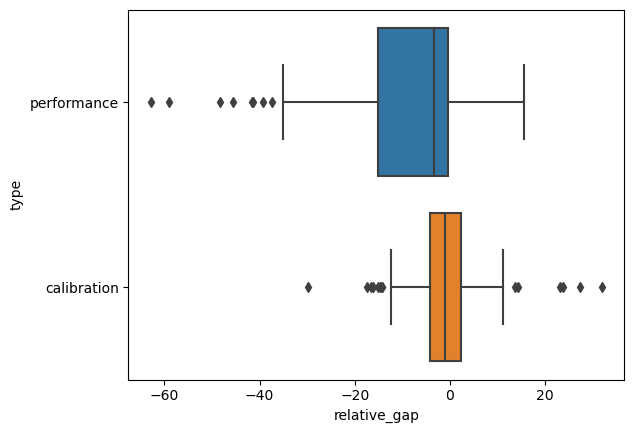

In [13]:
sns.boxplot(data=df, x="relative_gap", y="type")

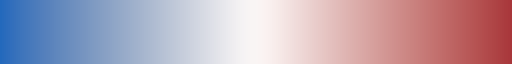

In [14]:
cmap1 = sns.color_palette("vlag", as_cmap=True)
cmap1

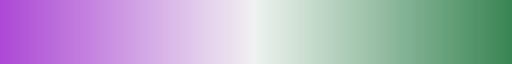

In [15]:
cmap2 = sns.diverging_palette(291, 138, as_cmap=True)
cmap2

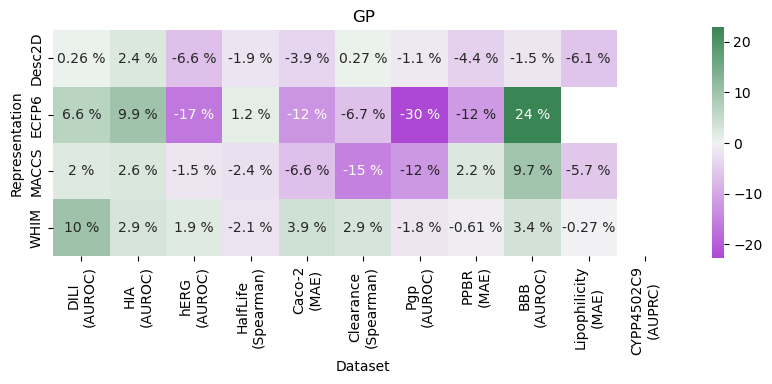

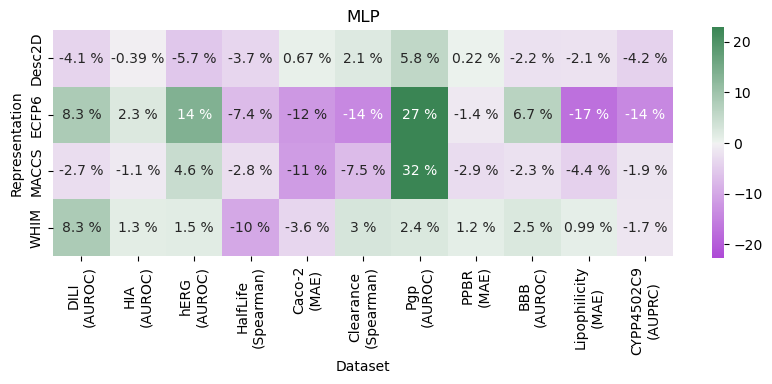

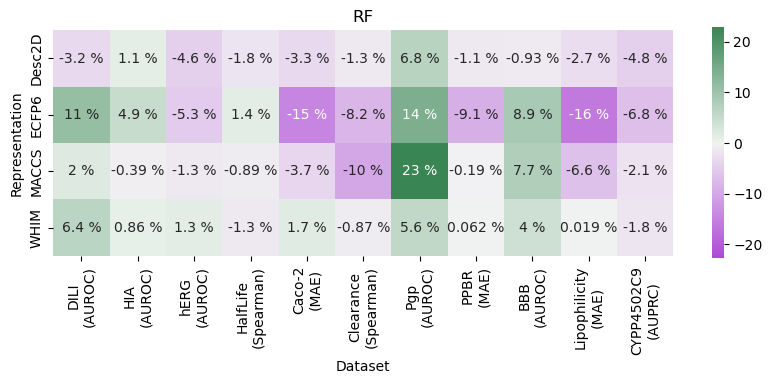

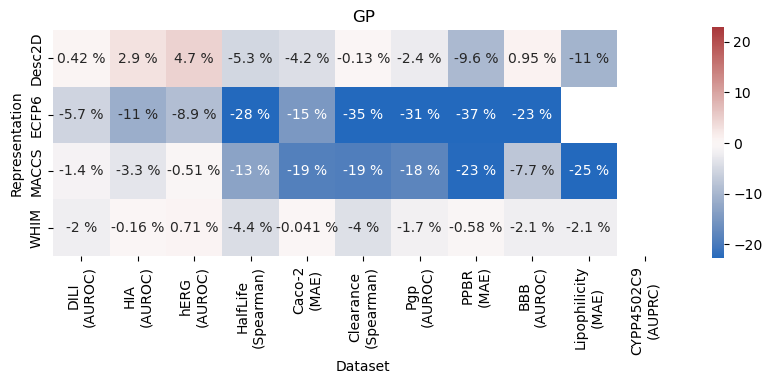

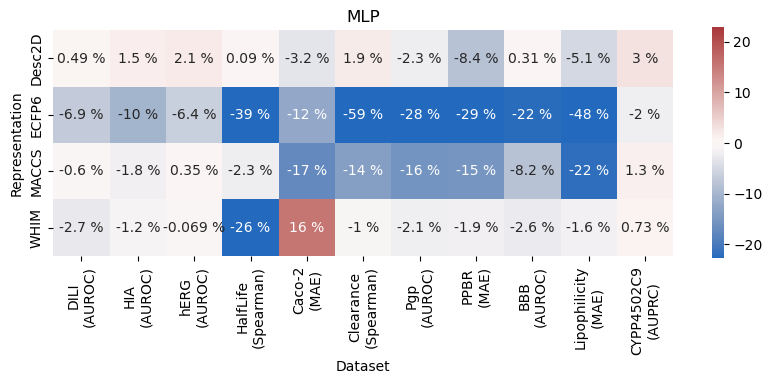

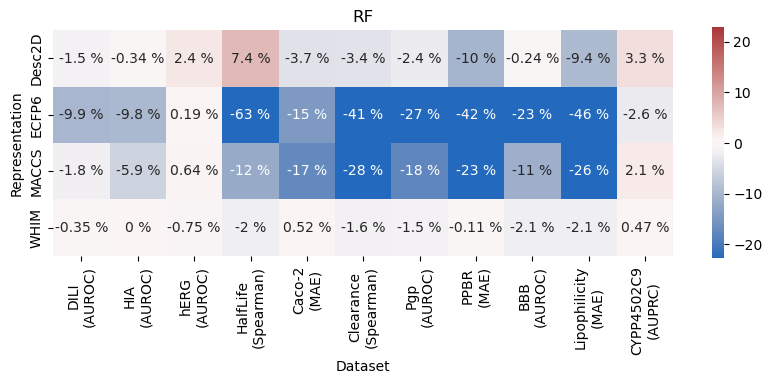

In [24]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
    
    if metric_type == "calibration":
        cmap = cmap2
    else:
        cmap = cmap1 
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, square=True)
        ax.set_xticklabels([f"{tick.get_text()}\n({TDC_TO_METRIC[tick.get_text()]})" for tick in ax.get_xticklabels()])
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(name)

The End.